# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
import random

from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
class KMeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        
        if random_state != None:
            np.random.seed(random_state)
        else:
            np.random.seed(10)
        
        self.metric = metric
        self.init = init
        self.max_iter = max_iter
        
        
            
    def initialize_centroids(self, X):
        """
        Процедура инициализации начальных значений центроидов
        """
        
        #epsilon
        self.eps = 0.001
        
        # Делаем случайные центры (k-means)
        if self.init == 'random':
            idxs = random.sample(xrange(X.shape[0]), self.k)
            self.centroids = X[idxs]
                
        # k-means++
        elif self.init == 'k-means':
            centr_idxs = [np.random.choice(X.shape[0], replace=False)]
            self.centroids = [X[centr_idxs[0]]]
            
            for centroids_num in xrange(1, self.k):
                dist = np.array(cdist(X, self.centroids).min(axis = 1) ** 2)
                dist /= np.sum(dist)
                
                while True:
                    curr_sum = 0
                    rand_sum = np.random.rand()
                    new_idx = 0 
                    for i in xrange(X.shape[0]):
                        curr_sum += dist[i]
                        new_idx = i
                        if curr_sum > rand_sum:
                            break
                    if (new_idx in centr_idxs) == False:
                        centr_idxs += [new_idx]
                        self.centroids += [X[new_idx, ]]
                        break

        self.centroids = np.array(self.centroids)

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        self.initialize_centroids(X)
        
        # k-means
        iter_num = 0
        for iter_num in xrange(self.max_iter):
            fixed_number = 0
            
            # Делим все на кластеры      
            self.labels = cdist(X, self.centroids).argmin(axis=1)
            
            # Пересчитываем центры            
            new_centroids = np.array([X[self.labels == i].mean(axis=0) for i in xrange(self.k)])
            self.centroids - new_centroids
            if ((self.centroids - new_centroids) ** 2).mean() < self.eps:
                break
            
            self.centroids = new_centroids.copy()
        
            iter_num += 1
                
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self.labels, self.centroids

class MiniBatchKMeans(KMeans):
    def __init__(self, k=2, batch_size=50, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :batch_size - количество
        """
        super(MiniBatchKMeans, self).__init__(k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        """
        Процедура обучения mini-batch k-means 
        """       
        # Матрица расстояний
        dist = np.empty((self.k, X.shape[0]))
        # Текущий размер кластеров
        cluster_sizes = np.zeros(self.k)
        
        self.initialize_centroids(X) 
                                         
        for iter_num in xrange(self.max_iter):
            old_centroids = np.copy(self.centroids)
            batch = X[np.random.randint(0, X.shape[0], size=self.batch_size)]
            dist = cdist(batch, self.centroids).argmin(axis=1)
            
            # Шаг алгоритма
            for point, curr_clast in zip(batch, dist):
                cluster_sizes[curr_clast] += 1
                theta = 1 / cluster_sizes[curr_clast]
                self.centroids[curr_clast] = (1 - theta) * self.centroids[curr_clast] + theta * point
            
            # Условие остановки
            if ((self.centroids - old_centroids) ** 2).mean() < self.eps:
                break               
            
            iter_num += 1
        # Метки
        self.labels = cdist(X, self.centroids).argmin(axis=1)

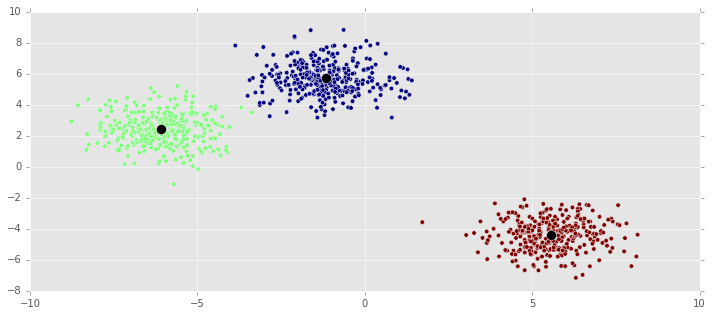

In [3]:
## Работоспособность KMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='random', random_state=123)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены.
# Вероятно, это происходит, когда две случайно выбранные начальные координаты центров попадают в один кластер.

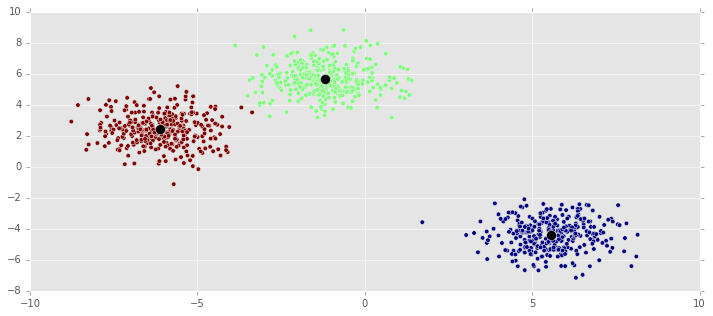

In [4]:
## Работоспособность KMeans++

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='k-means')
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены (вроде бы реже, чем при обычном k-means)
# Происходит это потому что выбор нового центроида тоже происходит случайно.

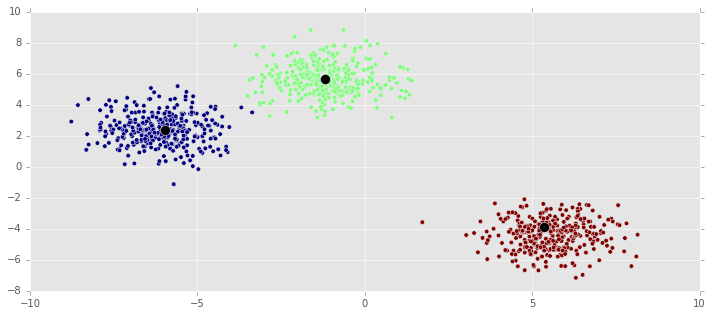

In [5]:
## Работоспособность KMeans с MiniBatchKMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
model = MiniBatchKMeans(k=3,  init='random', random_state=123, batch_size=50, max_iter=10)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

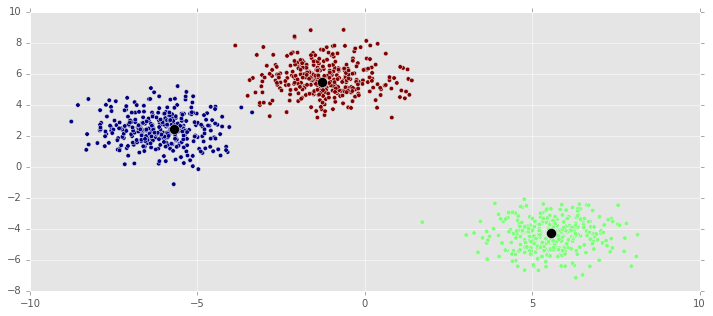

In [6]:
## Работоспособность KMeans++ с MiniBatchKMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = MiniBatchKMeans(k=3,  init='k-means', random_state=123, batch_size=50, max_iter=5)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

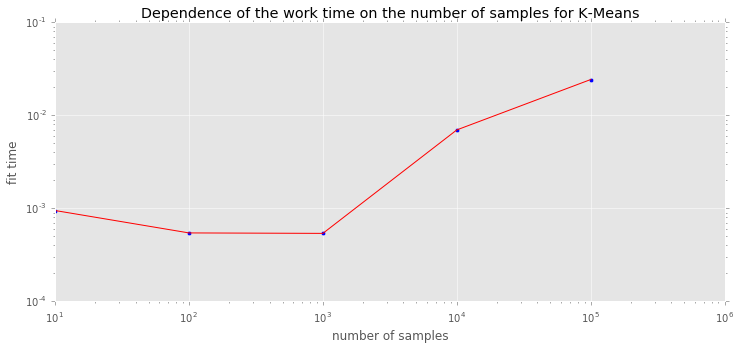

In [7]:
## Время выполнения алгоритма KMeans
samp_num = np.logspace(1, 5, num=5).astype(int)

times_kmeans = []
for num_samples in samp_num:
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = KMeans(k=3,  init='random', random_state=123)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times_kmeans += [time.best]
    

plt.plot(samp_num, times_kmeans, c='red')
plt.scatter(samp_num, times_kmeans, c='blue')

plt.title('Dependence of the work time on the number of samples for K-Means')
plt.xlabel('number of samples')
plt.ylabel('fit time')
plt.xscale('log')
plt.yscale('log')

plt.show() 

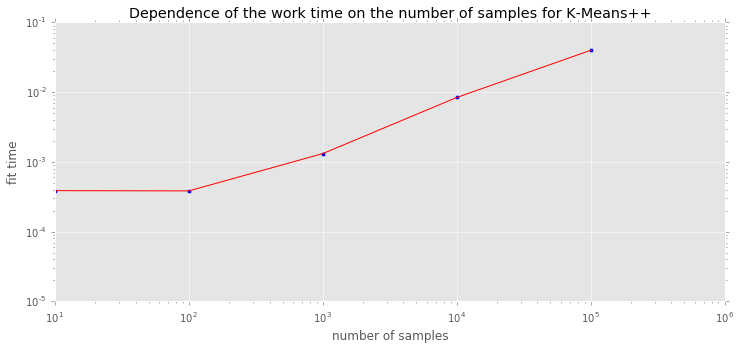

In [8]:
## Время выполнения алгоритма KMeans++

times_kmeanspp = []
for num_samples in samp_num:
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = KMeans(k=3,  init='k-means', random_state=123)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times_kmeanspp += [time.best]

plt.plot(samp_num, times_kmeanspp, c='red')
plt.scatter(samp_num, times_kmeanspp, c='blue')

plt.title('Dependence of the work time on the number of samples for K-Means++')
plt.xlabel('number of samples')
plt.ylabel('fit time')
plt.xscale('log')
plt.yscale('log')

plt.show()

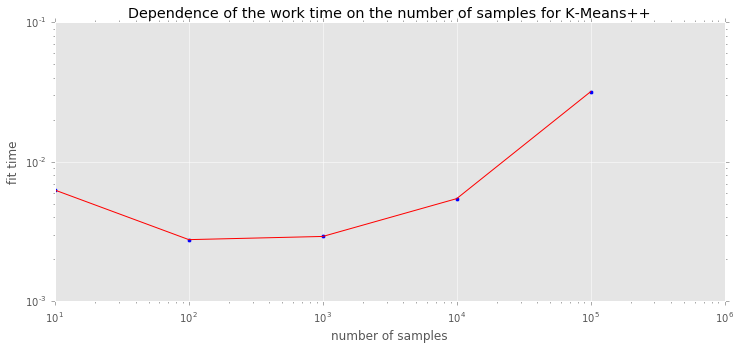

In [9]:
## Время выполнения алгоритма KMeans MiniBatch

times_kmeans_mb = []
for num_samples in samp_num:
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = MiniBatchKMeans(k=3,  init='k-means', random_state=123)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times_kmeans_mb += [time.best]

plt.plot(samp_num, times_kmeans_mb, c='red')
plt.scatter(samp_num, times_kmeans_mb, c='blue')

plt.title('Dependence of the work time on the number of samples for K-Means++')
plt.xlabel('number of samples')
plt.ylabel('fit time')
plt.xscale('log')
plt.yscale('log')


plt.show()

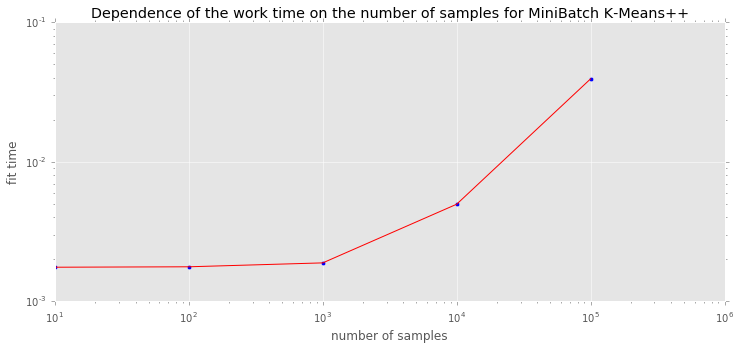

In [10]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

times_kmeans_mbpp = []
for num_samples in samp_num:
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = MiniBatchKMeans(k=3,  init='k-means', random_state=123, max_iter=5)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times_kmeans_mbpp += [time.best]

plt.plot(samp_num, times_kmeans_mbpp, c='red')
plt.scatter(samp_num, times_kmeans_mbpp, c='blue')

plt.title('Dependence of the work time on the number of samples for MiniBatch K-Means++')
plt.xlabel('number of samples')
plt.ylabel('fit time')
plt.xscale('log')
plt.yscale('log')

plt.show()

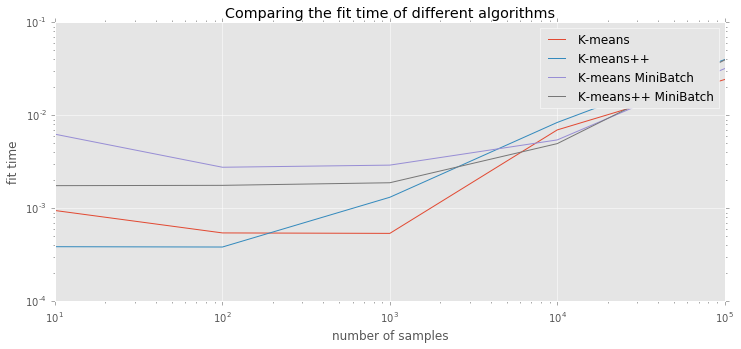

In [11]:
samp_num = np.logspace(1, 5, num=5).astype(int)
plt.plot(samp_num, times_kmeans, label='K-means')
plt.plot(samp_num, times_kmeanspp, label='K-means++')
plt.plot(samp_num, times_kmeans_mb, label='K-means MiniBatch')
plt.plot(samp_num, times_kmeans_mbpp, label='K-means++ MiniBatch')

plt.title('Comparing the fit time of different algorithms')
plt.xlabel('number of samples')
plt.ylabel('fit time')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

# Применение K-means на реальных данных

In [12]:
df_sns = pd.read_csv('snsdata.csv', sep=',').dropna()

In [13]:
X = df_sns.iloc[:, 4:].values
X_train = (X - X.mean(axis=0)) / X.std(axis=0)

In [14]:
df_sns = df_sns.drop(['gradyear','gender','age','friends'],axis=1)

Cluster #0


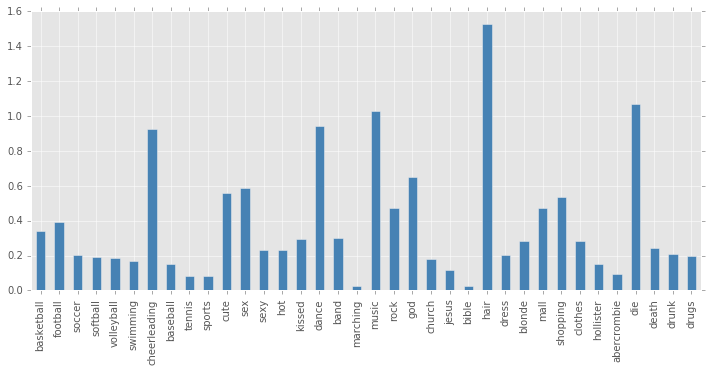

Cluster #1


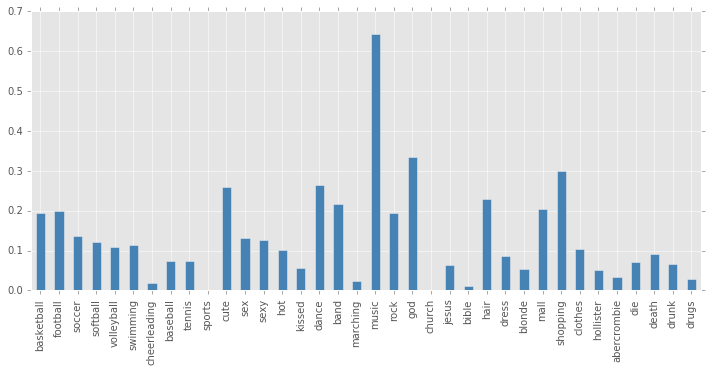

Cluster #2


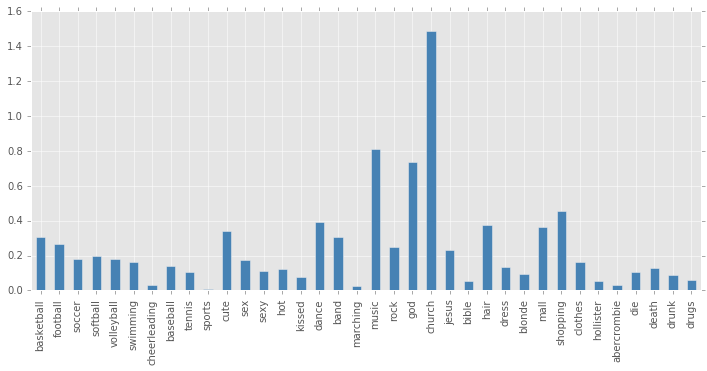

Cluster #3


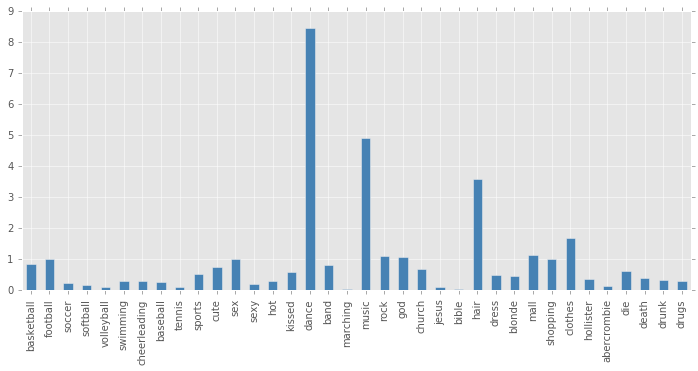

Cluster #4


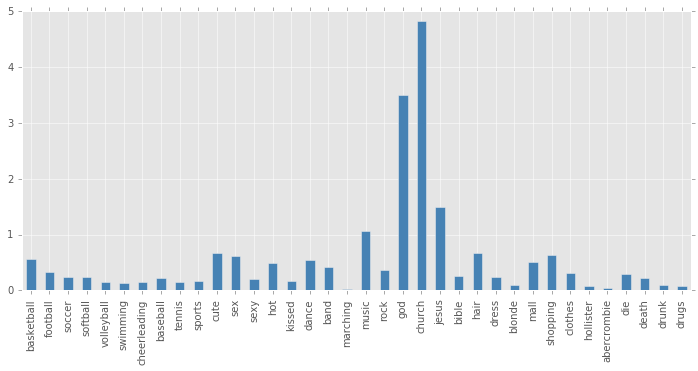

Cluster #5


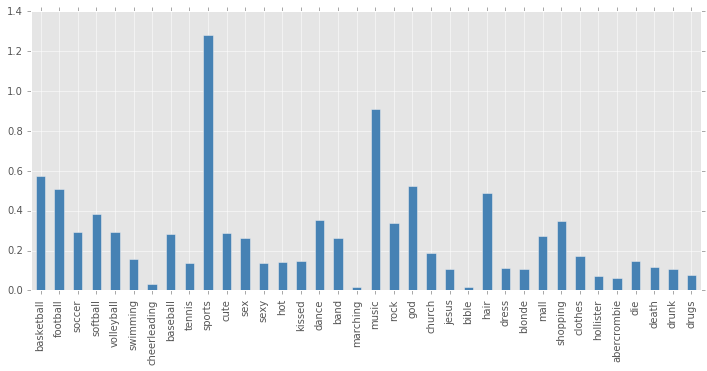

Cluster #6


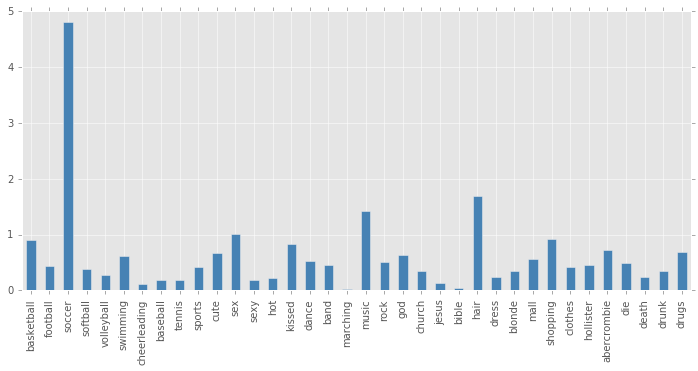

Cluster #7


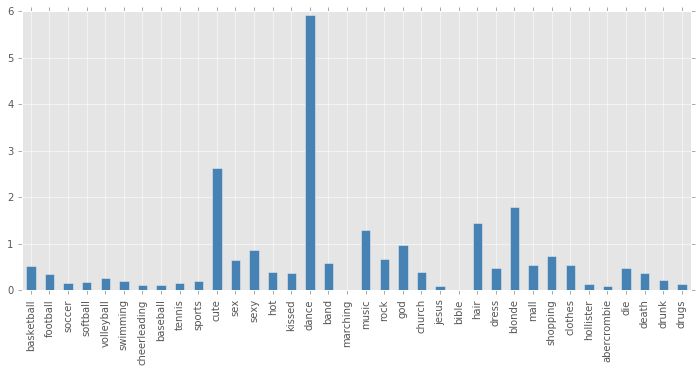

Cluster #8


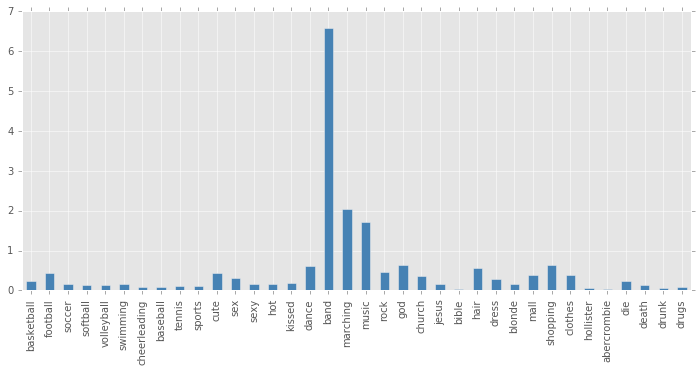

In [15]:
## KMeans
model = KMeans(k=9,  init='random', random_state=123, max_iter=1)
model.fit(X_train)
y, centers = model.predict(X_train)
df_sns['label'] = y

result = df_sns.groupby("label").agg(np.mean)
result= result.transpose()

for clust in xrange(9):
    print('Cluster #{}'.format(clust))
    result[clust].plot(kind='bar', color='steelblue')    
    plt.show()

Cluster #0


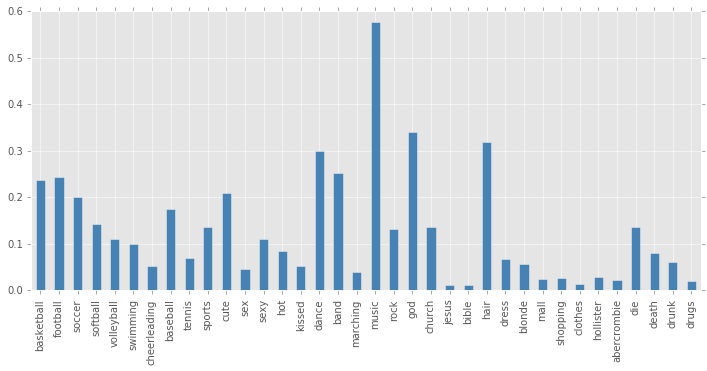

Cluster #1


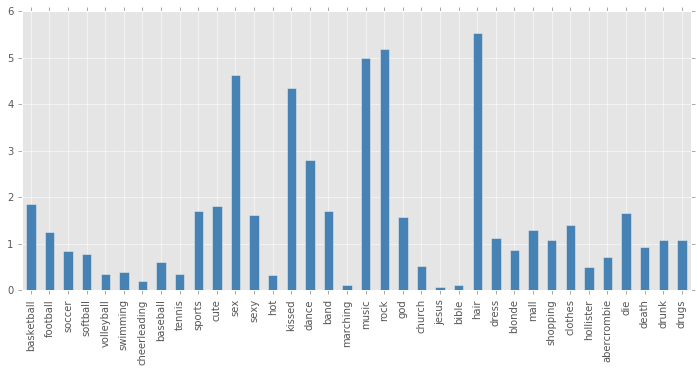

Cluster #2


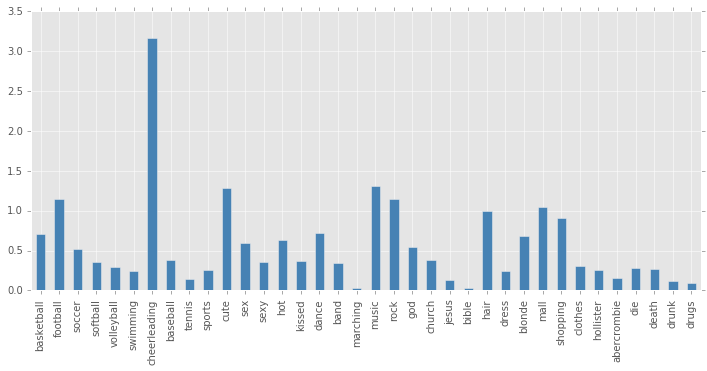

Cluster #3


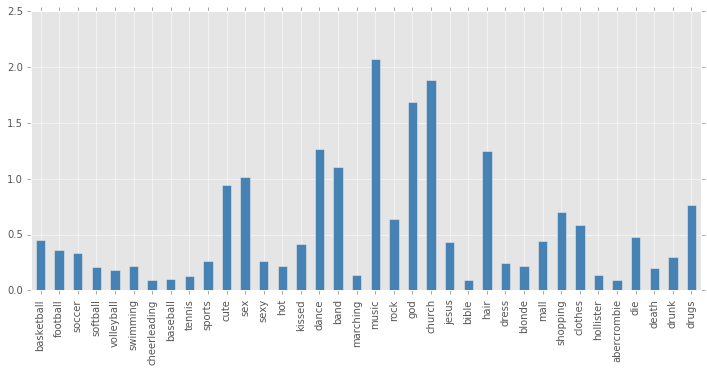

Cluster #4


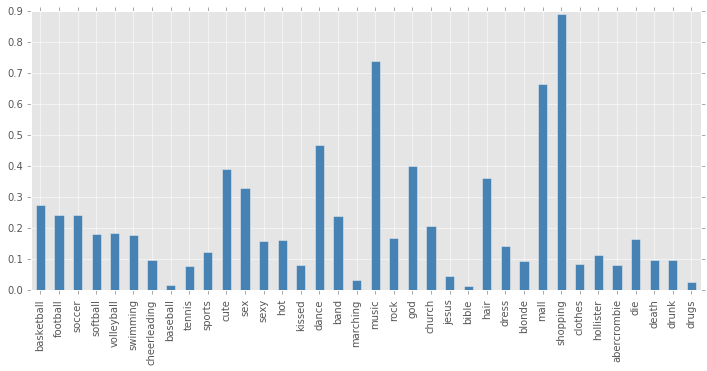

Cluster #5


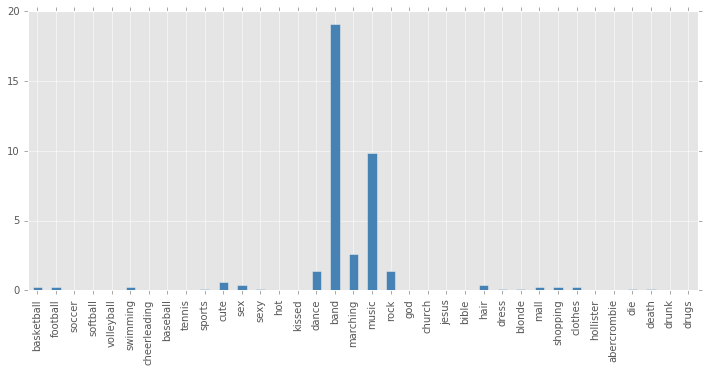

Cluster #6


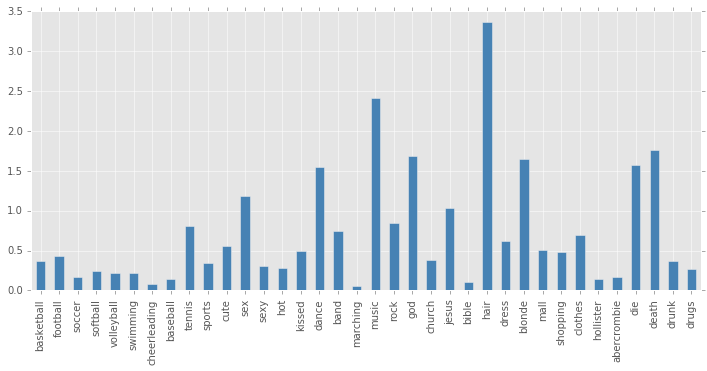

Cluster #7


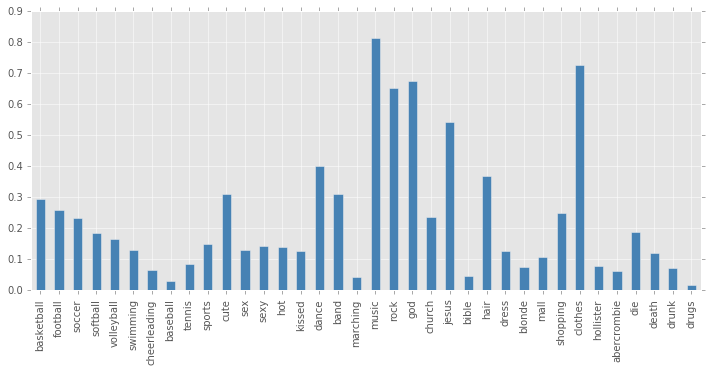

Cluster #8


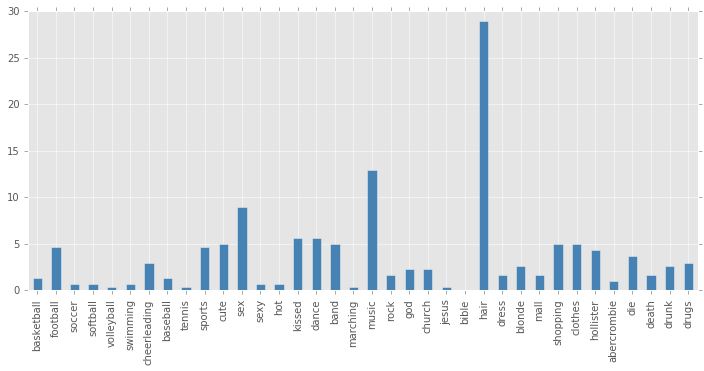

In [16]:
## KMeans++

model = KMeans(k=9,  init='k-means', random_state=123, max_iter=1)
model.fit(X_train)
y, centers = model.predict(X_train)
df_sns['label'] = y

result = df_sns.groupby("label").agg(np.mean)
result= result.transpose()

for clust in xrange(9):
    print('Cluster #{}'.format(clust))
    result[clust].plot(kind='bar', color='steelblue')    
    plt.show()

Cluster #0


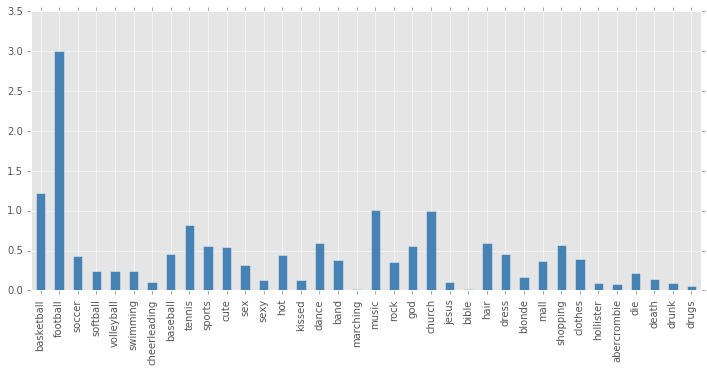

Cluster #1


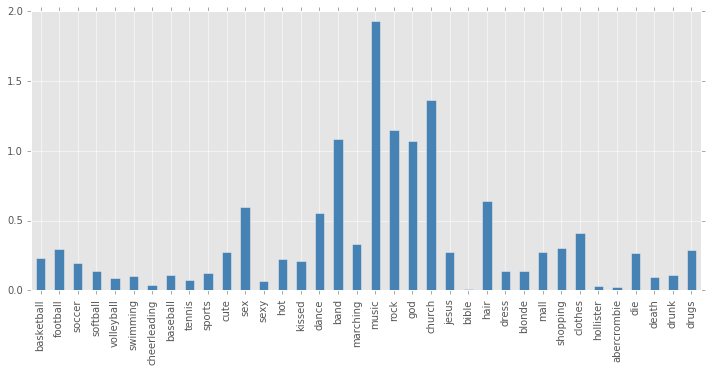

Cluster #2


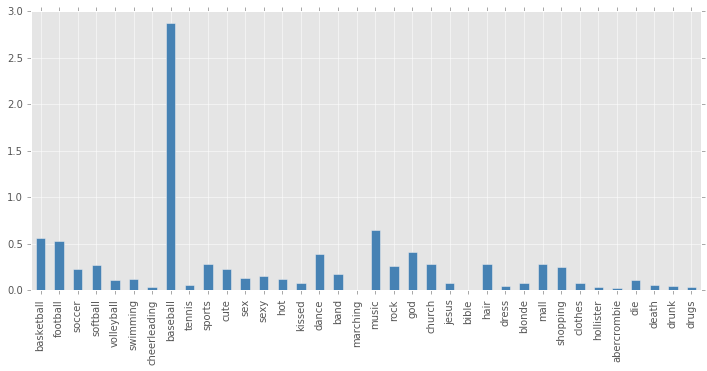

Cluster #3


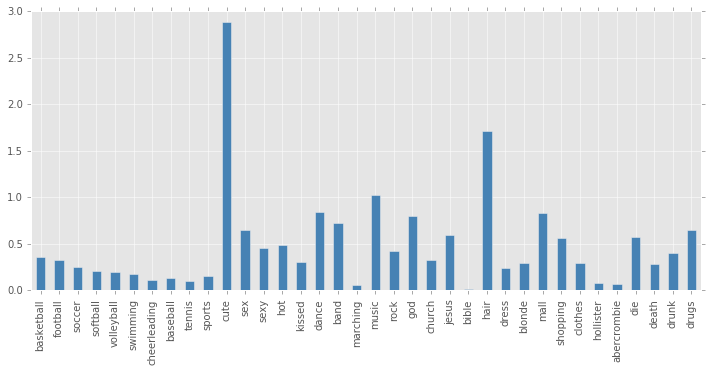

Cluster #4


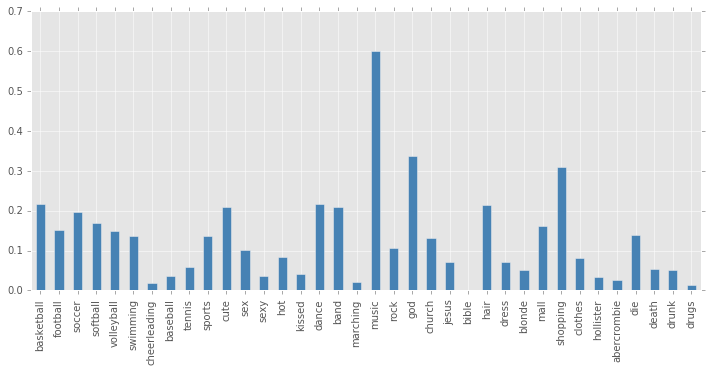

Cluster #5


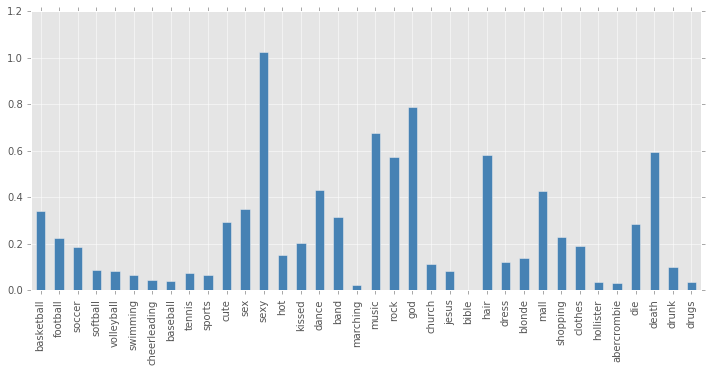

Cluster #6


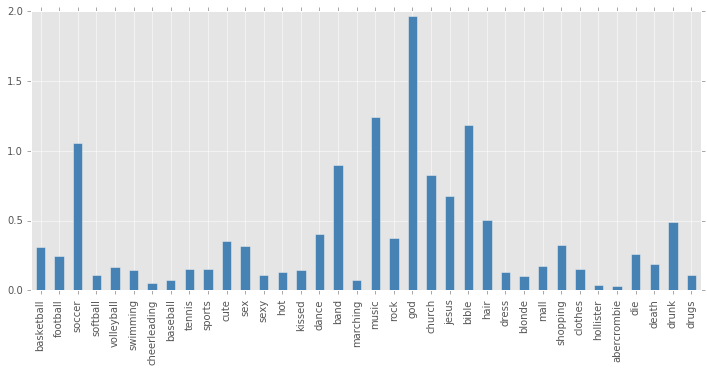

Cluster #7


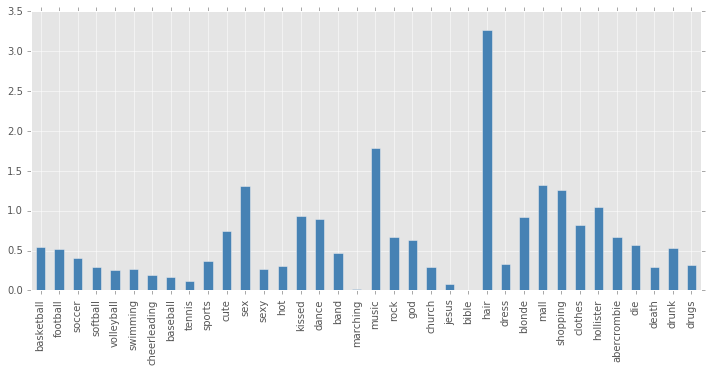

Cluster #8


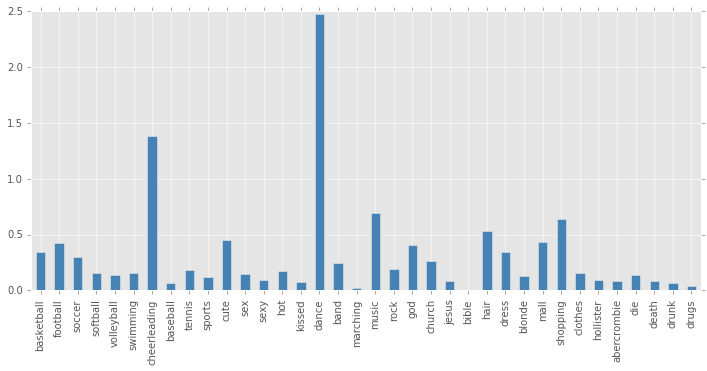

In [17]:
## KMeans с MiniBatchKMeans

model = MiniBatchKMeans(k=9,  init='random', random_state=123, max_iter=1)
model.fit(X_train)
y, centers = model.predict(X_train)
df_sns['label'] = y

result = df_sns.groupby("label").agg(np.mean)
result= result.transpose()

for clust in xrange(9):
    print('Cluster #{}'.format(clust))
    result[clust].plot(kind='bar', color='steelblue')    
    plt.show()

Cluster #0


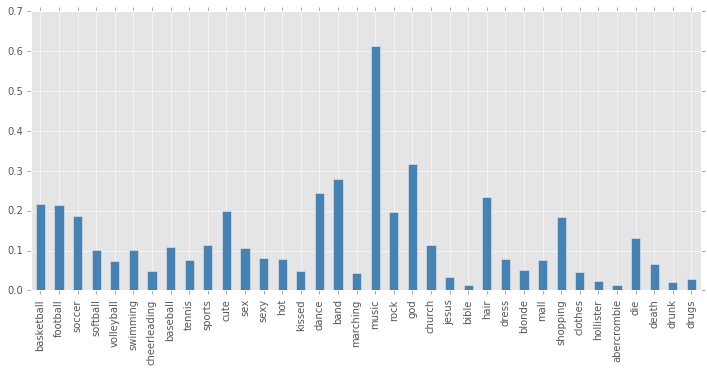

Cluster #1


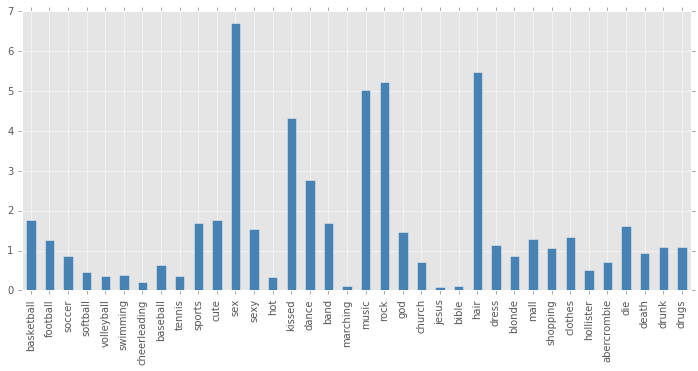

Cluster #2


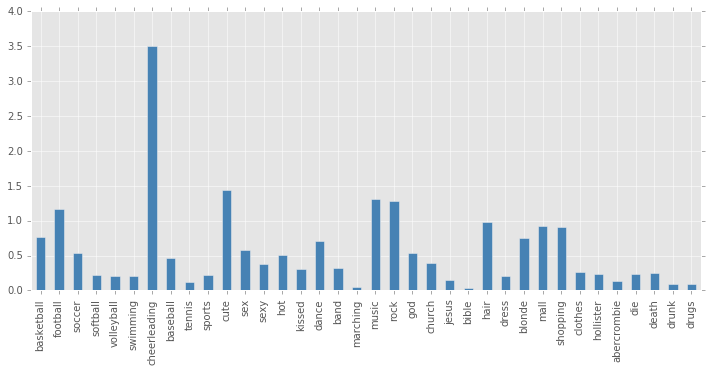

Cluster #3


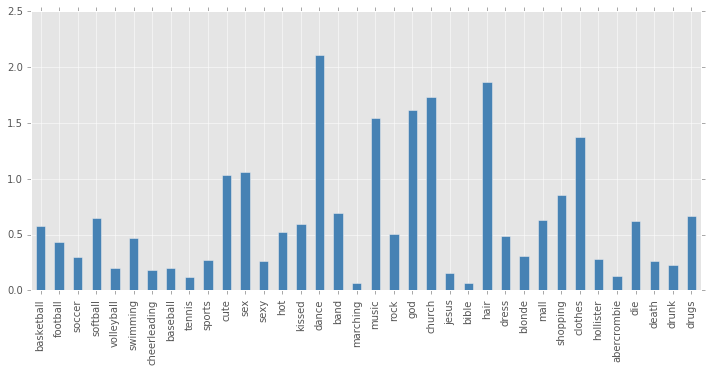

Cluster #4


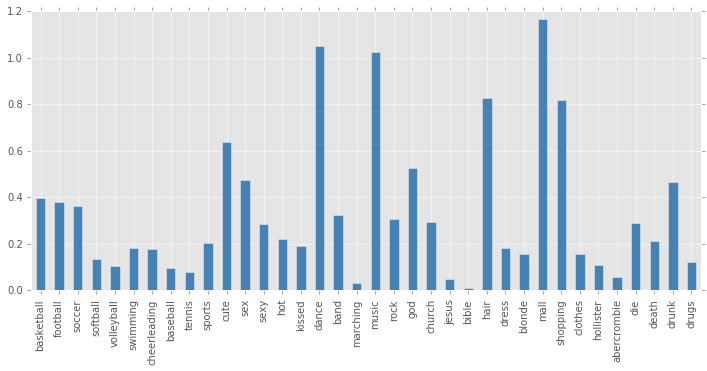

Cluster #5


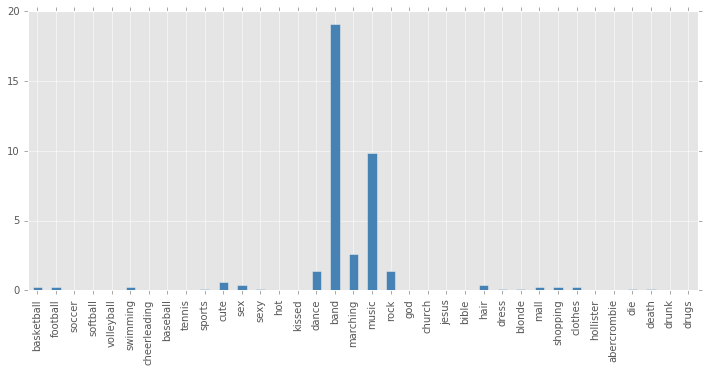

Cluster #6


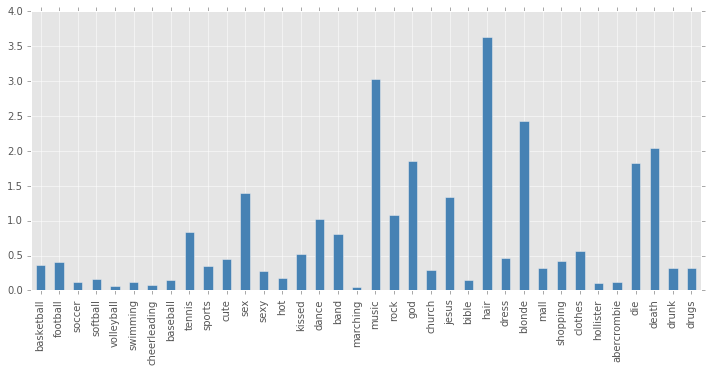

Cluster #7


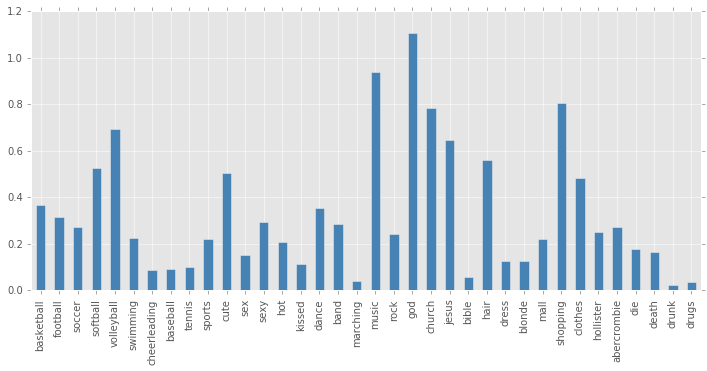

Cluster #8


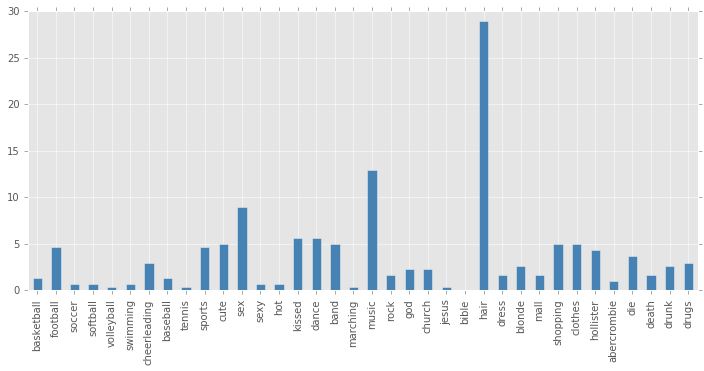

In [18]:
## KMeans++ с MiniBatchKMeans

model = MiniBatchKMeans(k=9,  init='k-means', random_state=123, max_iter=1)
model.fit(X_train)
y, centers = model.predict(X_train)
df_sns['label'] = y

result = df_sns.groupby("label").agg(np.mean)
result= result.transpose()

for clust in xrange(9):
    print('Cluster #{}'.format(clust))
    result[clust].plot(kind='bar', color='steelblue')    
    plt.show()

Все алгоритмы выделяют кластер черлидеров, кластер музыкантов и религиозных студентов. Также есть кластер, в который попали видимо девушки, которые интересуются прическами и размышляют о смерти.

## Выводы
У каждого метода свои достоинства и недостатки:
* KMeans: быстро и просто, но не всегда точно;
* KMeans++: дольше, но зато точнее;
* MiniBatch KMeans: быстрее KMeans на больших объемах данных;
* MiniBatch KMeans++: быстрее KMeans++ на больших объемах данных, точнее MiniBatch KMeans.

Нельзя сказать, что какой-то метод лучше других, каждый из них хорош для определенных задач. На больших объемах пригодится MiniBatch, а на маленьких можно и начальные центроиды неслучайно выбрать.